In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Загружаем данные в таблицу
df = pd.read_csv('AAPL.csv')

# Сортируем данные по дате
df = df.sort_values('Date')

# Выводим описание наших данных
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3089.000000,3089.000000,3089.000000,3089.000000,3089.000000,3.089000e+03
mean,54.408180,54.926004,53.841993,54.397401,45.305461,1.413024e+08
std,39.924409,40.219641,39.625588,39.930786,39.034974,1.031620e+08
min,4.556428,4.636428,4.471428,4.520714,3.048571,1.147590e+07
25%,17.458570,17.755714,17.185715,17.434286,11.756919,6.662250e+07
50%,47.828571,48.127144,47.411430,47.805714,32.238071,1.154377e+08
75%,89.692856,90.665718,89.048569,89.807144,68.650002,1.885058e+08
max,144.289993,145.460007,143.809998,144.770004,141.968033,8.432424e+08


In [3]:
# Выбираем столбец с максимальной ценой за день и представляем его в форме массива
high = df.loc[:,'High'].as_matrix()

# Аналогично для минимальной цены
low = df.loc[:,'Low'].as_matrix()

# Берем среднее арифметическое
average = (high + low) / 2

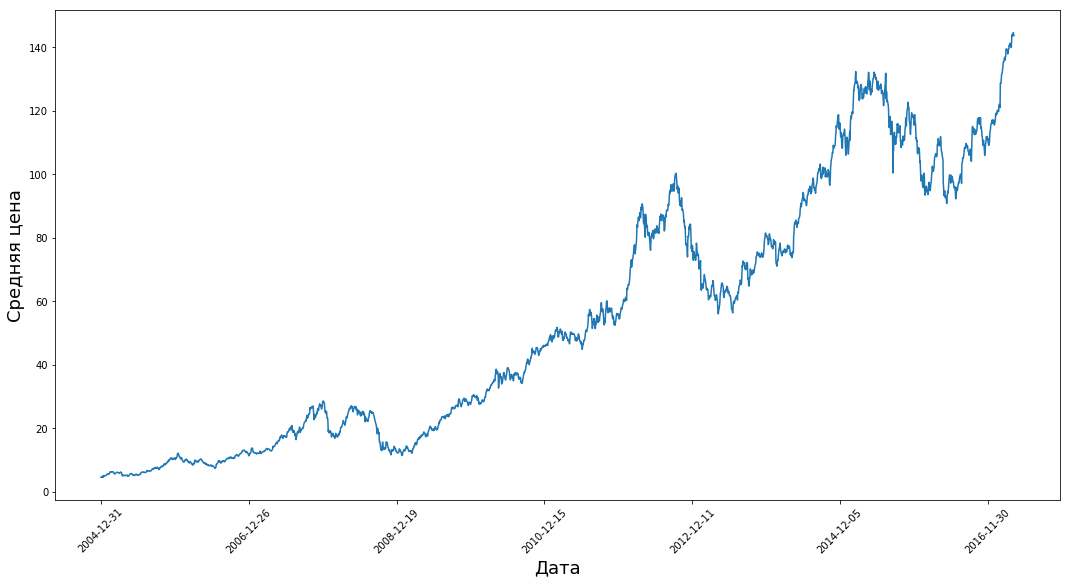

In [4]:
# Определяем размер нашей фигуры
plt.figure(figsize = (18,9))

# По оси абсцисс - числа от нуля до последнего индекса массива со средними, по оси ординат - сами показатели
plt.plot(range(len(average)), average)

# Настраиваем, как будет выглядить ось абсцисс
plt.xticks(range(0, len(average), 500),
           df['Date'].loc[::500], rotation=45)

# Именуем оси
plt.xlabel('Дата',fontsize=18)
plt.ylabel('Средняя цена',fontsize=18)
# Выводим получившийся график
plt.show()

In [5]:
# Количество "шагов вперед", то есть на сколько шагов мы будем делать предсказания
f_horizon = 1

# Размер каждой выборки с данными, которые будут подаваться на вход
batch_size = 300 

# Количество клеток в каждом скрытом слое LSTM
num_hidden = [200, 200, 150]

# Количество слоев (равно 3)
n_layers = len(num_hidden)

# Количество нейронов в последнем (выходном) слое
num_last = num_hidden[-1]

# Размерность входных данных: так как работаем с одномерными массивами, размерность равна 1
num_input = 1

# Размерность выходных данных: так как работаем с одномерными массивами, размерность равна 1
num_output = 1

# Количество эпох - сколько раз будет проводиться операция обучения
num_epochs = 10**(3) + 1

# Доля выбрасываемой на каждом шаге информации
dropout = 0.2 

In [6]:
# Тренировочным данным присваиваем первые 2700 значений, остальные данные отправляем в тестовые
train_data = average[:2700]
test_data = average[2700:]

In [7]:
# Объявляем переменную scaler нашим "нормализатором"; также преобразовываем данные в нужную нам размерность
scaler = MinMaxScaler()
train_data = train_data.reshape(-1, 1)
test_data = test_data.reshape(-1, 1)

In [8]:
# Иициализируем размер окна и производим нормализацию для каждой группы, настраивая scaler на тех же данных.
# После этого приводим данные к нужному нам виду
window_size = 300
for period in range(0, 2700, window_size):
    train_data[period:period + window_size, :] = scaler.fit_transform(
        train_data[period:period + window_size, :])

# Нормализуем оставшиеся данные
#train_data[period + window_size:, :] = scaler.fit_transform(train_data[period + window_size:, :])

# Приводим тренировочные данные к одномерному массиву
train_data = train_data.reshape(-1)

# Нормализуем тестовые и приводим их к одномернмоу массиву
test_data = scaler.transform(test_data).reshape(-1)

# Сохраним нормализованные данные целиком для последующих операций
new_data = np.concatenate([train_data, test_data])

# Обрезаем массив со всеми данными до количества "сколько раз batch_size полностью помещается в new_data" + f_horizon.
# Иными словами, мы отбрасываем ту часть new_data, в которой не сможет поместиться очередной batch_size, прибавляя f_horizon
# элементов new_data
new_data = new_data[:-(len(new_data) % batch_size) + f_horizon]

In [9]:
# Инициализируем переменные
gamma = 0.5
ema = 0
ema_length = len(new_data)
ema_pred = [ema] # В этот список добавляем значения EMA
ema_x = [] # В этот список добавляем даты
ema_mse = [] # В этот список добавляем среднеквадратичные ошибки

# Циклом предсказываем значение для периода t+1 на основе периода t
for pred_by_ema in range(0, ema_length - 1):
    ema = ema * gamma + (1 - gamma) * new_data[pred_by_ema]
    ema_pred.append(ema)
    ema_mse.append((ema_pred[-1] - new_data[pred_by_ema + 1])**2)
    
    date = df.loc[pred_by_ema + 1,'Date']
    ema_x.append(date)

# Выведем MSE для EMA-прогнозирования:
print(
    'MSE для предсказания EMA (Экспоненциального скользящего среднего) равно %.5f' % (
        np.mean(ema_mse)))

MSE для предсказания EMA (Экспоненциального скользящего среднего) равно 0.00334


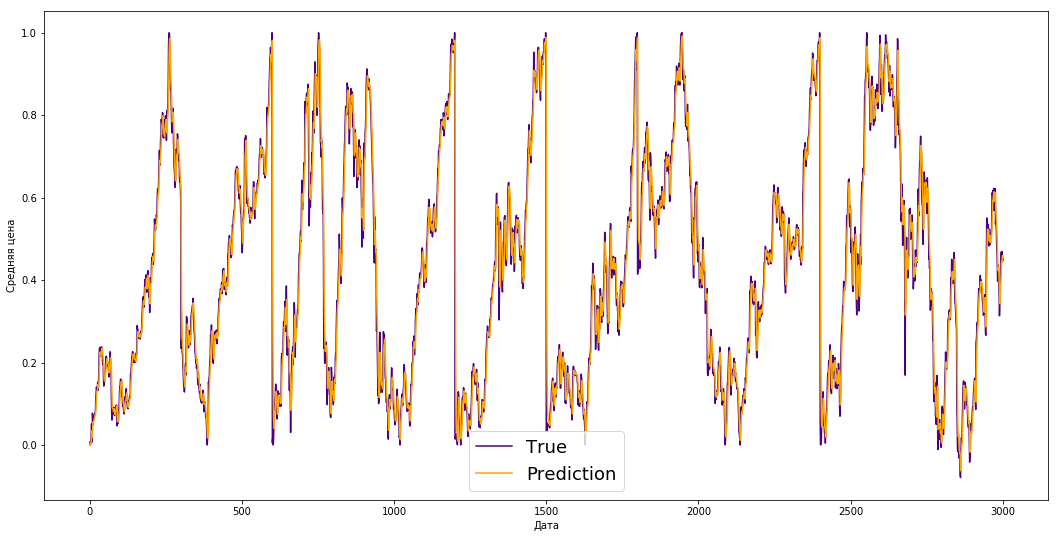

In [10]:
# По аналогии с предыдущим графиком
plt.figure(figsize=(18,9))
plt.plot(range(len(new_data)), new_data,
         color='Indigo', label='True')
plt.plot(range(0, ema_length), ema_pred,
         color='orange', label='Prediction')
#plt.xticks(range(0,range(len(average), 50), ema_x[::50], rotation=45)
plt.xlabel('Дата')
plt.ylabel('Средняя цена')
plt.legend(fontsize=18)
plt.show()

In [11]:
# Создаем тренировочную выборку и выводим размерность получившихся данных для проверки
def f_train_data(series, forecast, batch_size):
    x_data = series[:-(batch_size + forecast)]
    x_final = x_data.reshape(-1, batch_size, 1)
    y_data = series[forecast:-(batch_size)]
    y_final = y_data.reshape(-1, batch_size, 1)
    return x_final, y_final

x_batches, y_batches = f_train_data(new_data, f_horizon, batch_size)

print(x_batches.shape)
print(y_batches.shape)

(9, 300, 1)
(9, 300, 1)


In [12]:
# Создаем тестовую выборку и выводим размерность получившихся данных для проверки
def f_test_data(series, forecast, batch_size):
    test_X = series[-(batch_size + forecast):-forecast].reshape(
        -1, batch_size, 1)
    test_Y = series[-batch_size:].reshape(-1, batch_size, 1)
    return test_X, test_Y

X_test, y_test = f_test_data(new_data, f_horizon, batch_size)
print(X_test.shape)
print(y_test.shape)

(1, 300, 1)
(1, 300, 1)


In [13]:
# Необходимое действие при многократном запуске модели
tf.reset_default_graph()

In [14]:
# Инициализируем плейсхолдеры с входными данными, истинными значениями для них и скоростью обучения
X = tf.placeholder(tf.float32, [None, batch_size, num_input])
y = tf.placeholder(tf.float32, [None, batch_size, num_output])
learning_rate = tf.placeholder(tf.float32, shape=[])

In [15]:
# Определяем три скрытых слоя в LSTM. Аргумент initializer приравниваем к указанному, потому что он помогает лучше и быстрее настроить начальные веса
lstm_cells = [
    tf.contrib.rnn.LSTMCell(
        num_units=num_hidden[layer],
        state_is_tuple=True,
        initializer=tf.contrib.layers.xavier_initializer()
                           )
    for layer in range(n_layers)]

# Настраиваем фильтры - забывания, входной и выходной в каждом слое
drop_lstm_cells = [tf.contrib.rnn.DropoutWrapper(
    cell,
    input_keep_prob=1.0,
    output_keep_prob=1.0 - dropout,
    state_keep_prob=1.0 - dropout
) for cell in lstm_cells]

# Объединяем слои
drop_multi_cell = tf.contrib.rnn.MultiRNNCell(drop_lstm_cells)

Instructions for updating:
Use the retry module or similar alternatives.


In [16]:
# Создаем переменные состояния ячейки и скрытого состояния, которые будут хранить состояние LSTM.
c, h = [], []
initial_state = []
for layer in range(n_layers):
  c.append(tf.Variable(tf.zeros([batch_size, num_hidden[layer]]),
                       trainable=False))
  h.append(tf.Variable(tf.zeros([batch_size, num_hidden[layer]]),
                       trainable=False))
  initial_state.append(
      tf.contrib.rnn.LSTMStateTuple(
          c[layer], h[layer]))

In [17]:
# Создание непосредственно рекуррентной сети с заданными клетками
lstm_output, state = tf.nn.dynamic_rnn(
    drop_multi_cell, X, initial_state=tuple(initial_state),
    time_major=True, dtype=tf.float32)

In [18]:
# Приводим вывод сети к требуемому формату
lstm_output_new = tf.reshape(lstm_output, [-1, num_last])

# Добавляем линейный слой для правильного вывода данных
lstm_output_stacked = tf.layers.dense(lstm_output_new, num_output)

# Снова приводим данные к нужной форме
outputs = tf.reshape(lstm_output_stacked, [-1, batch_size, num_output])

In [19]:
# Определяем функцию ошибки
loss = tf.losses.mean_squared_error(outputs, y)

# Инициализируем оптимизатор
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

# Создаем переменную, которая будет минимизировать функцию ошибки с помощью данного оптимизатора
training_op = optimizer.minimize(loss)

In [20]:
# Инициализируем глобальные переменные
init = tf.global_variables_initializer()

In [21]:
# Запускаем процесс работы LSTM
with tf.Session() as sess:
    init.run()
    for each in range(num_epochs):
        
        # Запускаем LSTM, передавая значения в плейсхолдеры
        sess.run(
            training_op,
            feed_dict={
                X: x_batches,
                y: y_batches, learning_rate: 10**(-5) * each})
        
        # На каждой 100-й эпохе будем выводить величину ошибки
        if each % 100 == 0:
            mse = loss.eval(feed_dict={X: x_batches, y: y_batches})
            print('{0}\tMSE:{1}'.format(each, mse))
        
        # Определяем предсказанные значения
        y_pred = sess.run(outputs, feed_dict={X: X_test})

# При необходимости можно вывести предсказанные значения
#print(y_pred)

0	MSE:0.268512487411499
100	MSE:0.05721130222082138
200	MSE:0.0043883067555725574
300	MSE:0.0038759016897529364
400	MSE:0.003503387561067939
500	MSE:0.003457779763266444
600	MSE:0.0032563102431595325
700	MSE:0.0034797778353095055
800	MSE:0.003566622966900468
900	MSE:0.0031827047932893038
1000	MSE:0.0032374593429267406


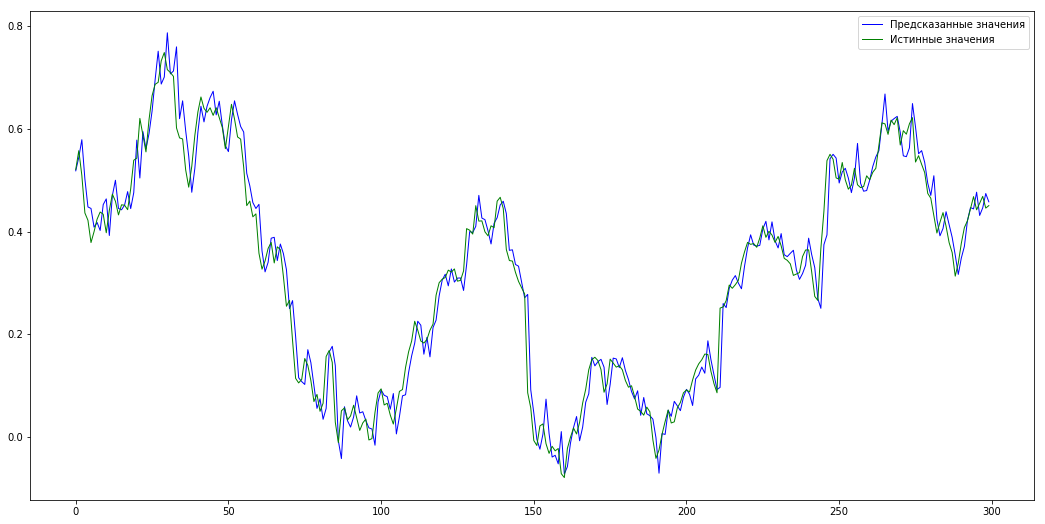

In [22]:
# Строим график с истинными и предсказанными значениями
plt.figure(figsize=(18, 9))
plt.plot(range(300), np.ravel(y_pred), c='b',
         linewidth=1, label='Предсказанные значения')
plt.plot(range(300), np.ravel(y_test), c='g',
         linewidth=1, label='Истинные значения')
plt.legend()
plt.show()